# RISM - A Gentle Introduction

We are going to write a Python implementation of the extended RISM equation with the goal of computing the direct, indirect and total correlation function along with the radial distribution function.

First, we import the libraries we will be needing:

In [135]:
import numpy as np
from scipy.fftpack import dstn, idstn
import matplotlib.pyplot as plt

First, we need to set up our problem domain. While the RISM equations are written as continuous functions $r$ (e.g. $c(r)$), computationally we solve them on a discretised grid.

We'll set up a discrete domain of length (or radius since we are working with spherically symmetric functions) $r = 15\, Å$ partitioned into $N = 100$ points. The resulting grid spacing is given by $\Delta r = \frac{r}{N}$.

In [136]:
r = 15.0
N = 100
dr = r / N

We also want to set up a grid spacing for our Fourier-space grid such that $\Delta r \Delta k = \frac{\pi}{N}$

In [137]:
dk = 2.0 * np.pi / (2.0 * N * dr)

Lets check the equality we stated above:

In [138]:
np.isclose(dr * dk, np.pi / N)

True

We use `np.isclose()` here because we are comparing floating point numbers. Using `==` would not work since there is always some precision loss with floats. You need to compared them within tolerances instead.

We can use these to generate our real and Fourier-space midpoint grids.

In [139]:
r_grid = np.arange(0.5, N, 1.0) * dr
k_grid = np.arange(0.5, N, 1.0) * dk

## Simple Lennard-Jones Argon Liquid

Now that we have our problem domain set up, we can focus on solving a particular problem. We're going to look at solving RISM for a simple Lennard-Jones Argon liquid.

We first need to set up the thermodynamical state of the system and the unit systems we're going to use. We'll be working with energies in kJ / mol.

In [140]:
T = 85.0 # Kelvin
kB = 8.314462618e-3 # kJ / mol / K
beta = 1.0 / T / kB # Thermodynamic Beta
ns = 1 # Number of sites

We also need to define the parameters for Argon, as well as its number density. 

In [141]:
ar_epsilon = 120.0 * 8.314462618e-3  # kJ / mol
ar_sigma = 3.4 # Angstroms
ar_dens = 0.021017479720736955 # 1 / Angstrom^3
ar_rho = np.diag([ar_dens]) # Number density as a "matrix"

We need to tabulate the LJ potential with the above parameters. We define a function to evaluate the potential over a grid, and then we plot the potential.

In [142]:
def LJ(epsilon, sigma, r):
    return 4.0 * epsilon * ( np.power( (sigma / r), 12) - np.power( (sigma / r), 6) )

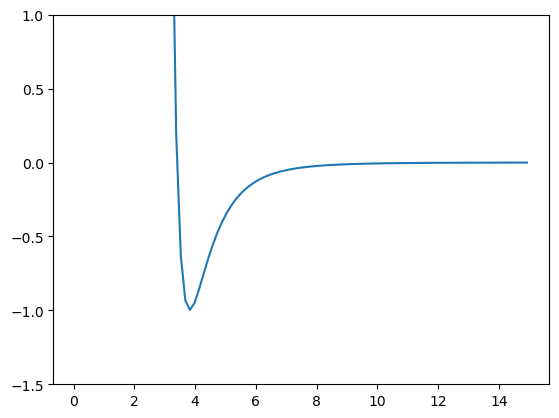

In [143]:
ar_ur = np.zeros((N, ns, ns))
ar_ur[:, 0, 0] = LJ(ar_epsilon, ar_sigma, r_grid)

plt.plot(r_grid, ar_ur[:, 0, 0])
plt.ylim([-1.5, 1.0])
plt.show()

One aspect of the RISM equation that we need to consider is the intramolecular correlation function $\omega(k)$. In the case of a simple liquid, $\omega(k) = 1$, in which case we the RISM equation reduces to the Ornstein-Zernike (OZ) equation.
We'll implement the full RISM equation, but we will set $\omega(k)$ to 1 for the case our current system.

Notice that we are setting up a 3D array, even though we just defined `ns = 1` above. This is because we plan to model molecular system later, where ns will be greater than 1. Setting up the maths for proper array sizes now means we don't need to refactor that aspect later.

In [144]:
ar_wk = np.ones((N, ns, ns))

Another aspect is the closure. The closure is what relates our unknowns ($h(r)$ and $c(r)$), in a sense "closing" the RISM equation.
Generally the closure in terms of $c(r)$ is $$ c(r) = e^{-\beta u(r) + t(r) - B(r)} - t(r) - 1 $$ where $B(r)$ is the bridge function - something that we need to approximate - and $t(r) = h(r) - c(r)$ is the indirect correlation function.

We're going to use the simplest approximation, $B(r) = 0$. This is the Hypernetted Chain (HNC) closure.

$$ c(r) = e^{-\beta u(r) + t(r)} - t(r) - 1 $$

In [145]:
def HNC(beta, ur, tr):
    return np.exp(-beta * ur + tr) - 1.0 - tr

The final detail before we implement the RISM equation is that we need to be able to transform our correlation functions into Fourier-space and back.
We use the Fourier transforms of spherically symmetric functions:

$$ f(k) = 4 \pi \int_0^\infty f(r) r^2 \frac{\sin(kr)}{kr} dr $$

and the inverse:

$$ f(r) = \frac{1}{2 \pi^2} \int_0^\infty f(k) k^2 \frac{\sin(kr)}{kr} dk $$

The function $J_0(kr) = \frac{\sin(kr)}{kr}$ is the zeroth-order spherical Bessel function of the first kind, so sometimes these transforms are called Fourier-Bessel (or Hankel) transforms.

This can neatly be related to the Fourier sine transform:

$$ f(k) = \int_0^\infty f(r) \sin(kr) dr $$

$$ f(r) = \frac{2}{\pi} \int_0^\infty f(k) \sin(kr) dk $$

So that the fourier transform of the spherically symmetric function $f(r)$ is just the Fourier sine transform of the function $f(r) \cdot r$

Scipy has discrete sine transform functions we can use. We use `newaxis` here to allow for broadcasting arrays of different dimensions together, since, for example, the `fbt` function takes `fr` as argument which is dimension N x ns x ns, and multiplies it by `r` which is dimension N. We use newaxis to allow `r` to be broadcast over all `ns x ns` components of `fr`

In [146]:
def fbt(fr, r, k, dr):
    return 2.0 * np.pi * dr * dstn(fr * r[:, np.newaxis, np.newaxis], type=4, axes=[0]) / k[:, np.newaxis, np.newaxis]

def ifbt(fk, r, k, dk):
    return dk / 4.0 / np.pi / np.pi * idstn(fk * k[:, np.newaxis, np.newaxis], type=4, axes=[0]) / r[:, np.newaxis, np.newaxis]

We have all the key parts to solve the RISM equation now.
The equation in Fourier-space is $$h(k) = \omega(k) * c(k) * \omega(k) - \rho * \omega(k) * c(k) * h(k)$$
We can rearrange this for $h(k)$ $$h(k) = [I - \rho * \omega(k) * c(k)]^{-1} \omega(k) * c(k) * \omega(k)$$

For brevity, I'm going to drop the function argument $(k)$ and $*$
$$h = [I - \rho\omega c]^{-1} \omega c \omega$$

We're interested in calculating the indirect correlation function $t(k)$ $$t = [I - \rho\omega c]^{-1} \omega c \omega - c$$

In [147]:
def RISM(cr, w, p, r, k, dr, dk):
    N = r.shape[0]
    I = np.eye(w.shape[1])
    tk = np.zeros_like(cr)
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)
    # Solve the RISM equation for t(k)
    for l in np.arange(0, N): # loop over grid points and perform matmuls for the corresponding matrices
        A = np.linalg.inv(I - p @ w[l] @ ck[l])
        B = w[l] @ ck[l] @ w[l]
        tk[l] = A @ B - ck[l]
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr

We have all the equations we need to perform a single closure and RISM calculation. Now we need to numerically solve this problem.

The RISM equation is an integro-differential equation, and is posed to be solved using fixed-point iteration (similar to the self-consistent approach used in electronic structure theory e.g. for solving Hartree-Fock).

We set some initial guess for $t_0(r)$, and use that as input into the closure and RISM equation, and get a new value out. If we represent the closure and RISM equation as an operator $F(\cdot)$ on $t(r)$ then we get a value of $F(t(r))$.

We can then mix this new value with our initial value to obtain a new solution for $t(r)$ $$t_1(r) = \alpha F(t_0(r))  + (1 - \alpha) t_0(r) $$

More generally $$t_{k+1}(r) = \alpha F(t_k(r)) + (1 + \alpha) t_k(r)$$

where $\alpha$ is a dampening parameter. The lower this is, the stiffer our iteration process is (because we're including more of the previous solution than the current). This is called Picard iteration.


We keep iterating this set of equations and check the difference between current and previous solutions until that difference is below some tolerance $\zeta$ $$ \left\Vert t_{k+1}(r) - t_{k}(r) \right\Vert_2 < \zeta $$ where $\left\Vert f(x) \right\Vert_2 = \sqrt{\int_0^1 \left|f(x)\right|^2\, dx}$ is the $L^2$-norm. In our case, the integral in the norm is over the full radius `L` that we defined earlier $$ \left\Vert t_{k+1}(r) - t_{k}(r) \right\Vert_2 = \sqrt{\int_0^L \left| t_{k+1}(r) - t_{k}(r) \right|^2\, dr}$$

Once the difference is below this tolerance, the calculation is finished.

We use an initial guess of $t(r) = 0$ and a tolerance of $\zeta = 1\times10^{-5}$

First, we define a function for our Picard iteration.

In [148]:
def picard_iteration(tolerance, max_step, alpha, initial_tr, beta, ur, wk, rho):
    # Set up our loop variable tr
    tr = initial_tr
    
    # Define our counter
    step = 0
    
    while True:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = HNC(beta, ur, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, wk, rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev

        # Check the L^2 norm between iterates
        norm = np.sqrt(np.power((tr_new - tr_prev), 2).sum() * dr)

        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step every 100 steps and difference
        if step % 100 == 0:
            print("Iteration: {step} Norm: {norm:.2e}".format(step=step, norm=norm))

        # Test if the difference is below our tolerance
        if norm < tolerance:
            print("Final Iteration: {step} Norm: {norm:.2e}".format(step=step, norm=norm))
            break
        
        # If we reach max_step, raise an error!
        if step == max_step:
            print("Reached max steps!")
            break

         # If any value is nan then the solver has diverged
        if np.any(np.isnan(tr)):
            print("Diverged at iteration: {step}".format(step=step))
            break

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1
    
    # Return solved t(r)
    return tr


Then, we set up our solver parameters

In [149]:
# Setting up parameters for iterations
tolerance = 1e-7 # Convergenc criterion
max_step = 10000 # Max number of steps before stopping calculation if convergence criteron not met
alpha = 0.3 # Damping parameter for Picard iteration
initial_tr = np.zeros((N, ns, ns)) # Initial guess of 0



Before going on, I want to introduce another method to aid convergence. A drawback of Picard iteration is its poor convergence properties when it comes to RISM - both that it takes a long time to converge and diverges easily.

A way to mitigate this is through using a process called charging - we solve a simpler RISM problem by scaling the potential down by some factor $\lambda$, the solution of which is used as an initial guess to a more complex problem where the potential is scaled by some factor $\lambda + \Delta \lambda$.

In this we case we use $\lambda = \left(0.25, 0.5, 0.75, 1.0 \right)$. You can think of this as slowly switching on the interaction between an argon particle and the bulk of the liquid.

This process is more generally used in computational chemistry for calculating free energies (e.g. Thermodynamic Integration, Free Energy Perturbation, Kirkwood Charging).

We are using it purely as a numerical tool to aid convergence. In this context, what we're doing is a specific application of a more general approach called numerical continuation (specifically natural parameter continuation). Numerical continuation is used to explore the space of solutions of a problem in order to test for brancing paths, but it is also used to mitigate issues that can arise due to poor initial guesses.


In [150]:
lambdas = 4

for ilam in range(1, lambdas+1):
    lam = ilam / lambdas
    print("Current Lambda: ", lam)
    tr = tr = picard_iteration(tolerance, max_step, alpha, initial_tr, beta, lam * ar_ur, ar_wk, ar_rho)
    initial_tr = tr

cr = HNC(beta, ar_ur, tr)

0.25
Iteration: 0 Norm: 6.67e-01
Iteration: 100 Norm: 3.28e-02
Iteration: 200 Norm: 5.64e-03
Iteration: 300 Norm: 1.03e-03


Iteration: 400 Norm: 1.90e-04
Iteration: 500 Norm: 3.51e-05
Iteration: 600 Norm: 6.49e-06
Iteration: 700 Norm: 1.20e-06
Iteration: 800 Norm: 2.22e-07
Final Iteration: 848 Norm: 9.86e-08
0.5
Iteration: 0 Norm: 8.36e-01
Iteration: 100 Norm: 1.45e-02
Iteration: 200 Norm: 4.30e-03
Iteration: 300 Norm: 1.31e-03
Iteration: 400 Norm: 3.99e-04
Iteration: 500 Norm: 1.22e-04
Iteration: 600 Norm: 3.75e-05
Iteration: 700 Norm: 1.15e-05
Iteration: 800 Norm: 3.53e-06
Iteration: 900 Norm: 1.08e-06
Iteration: 1000 Norm: 3.32e-07
Iteration: 1100 Norm: 1.02e-07
Final Iteration: 1102 Norm: 9.94e-08
0.75
Iteration: 0 Norm: 1.59e+00
Iteration: 100 Norm: 9.56e-03
Iteration: 200 Norm: 3.61e-03
Iteration: 300 Norm: 1.38e-03
Iteration: 400 Norm: 5.31e-04
Iteration: 500 Norm: 2.04e-04
Iteration: 600 Norm: 7.89e-05
Iteration: 700 Norm: 3.04e-05
Iteration: 800 Norm: 1.17e-05
Iteration: 900 Norm: 4.53e-06
Iteration: 1000 Norm: 1.75e-06
Iteration: 1100 Norm: 6.74e-07
Iteration: 1200 Norm: 2.60e-07
Iteration: 1300 N

Once solved, we can use the calculated correlation functions to calculate the radial distribution function and plot it.

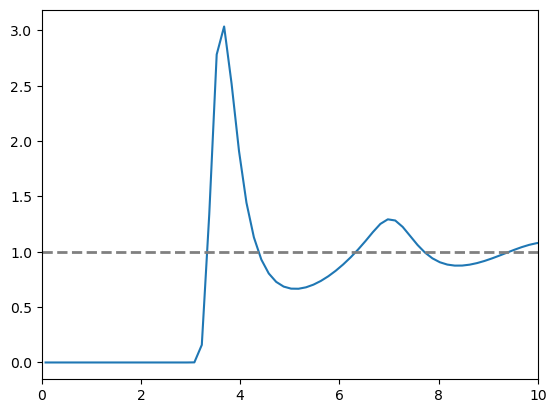

In [151]:
# Get h(r)
hr = tr + cr

# Get and plot g(r)
gr = hr + 1

plt.plot(r_grid, gr[:, 0, 0])
plt.xlim([0, 10])
plt.axhline(1, color="grey", linestyle="--", linewidth=2)
plt.show()

This is the radial distribution function for a Lennard-Jones liquid!

On your machine you might find that it took over 1000 iterations to come to a solution.
We're using a very simple iteration scheme, but there are more complex iteration schemes we can use that can reduce the number of iterations, but that's beyond the scope of this tutorial.